In [1]:
import os
import warnings
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gamma, norm, expon
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

In [3]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [4]:
# initialising min max scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

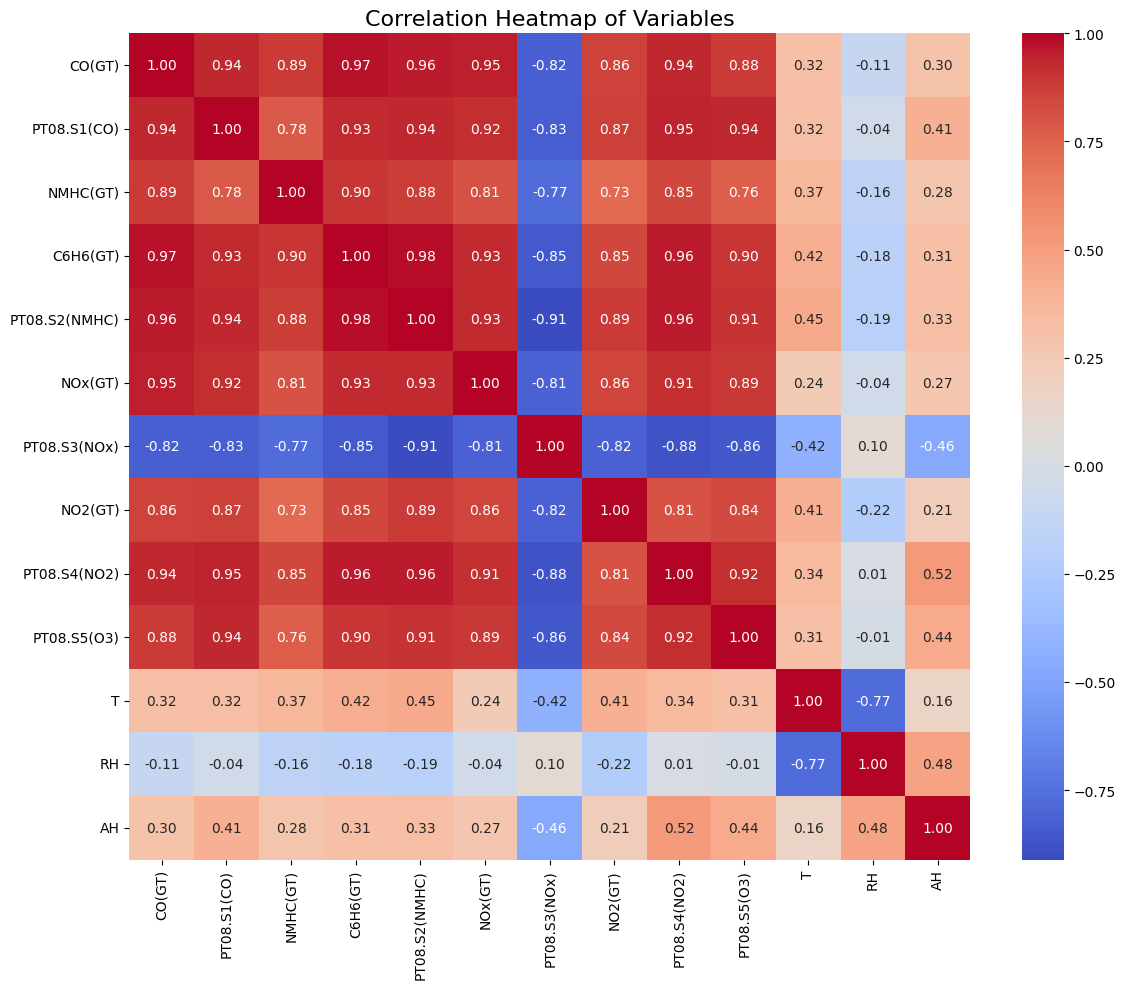

In [5]:
# Calculate the correlation matrix
correlation_matrix = scaled_data.corr()#data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_after_transformation.png")
plt.show()


In [6]:
# Define the target and predictor variables
target_variable = 'C6H6(GT)'
predictor_variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Subset the data to include only the target and predictor variablesa
# data = data[[target_variable] + predictor_variables].dropna()
scaled_data = scaled_data[[target_variable] + predictor_variables].dropna()

In [7]:
# Prepare predictors and target
X = scaled_data[predictor_variables]
y = scaled_data[target_variable]

In [8]:
# Ensure target variable is positive
if (y <= 0).any():
    print("[Info:] Target variable contains non-positive values. Adjusting...")
    y += 0.001

[Info:] Target variable contains non-positive values. Adjusting...


In [9]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

Cluster Determination

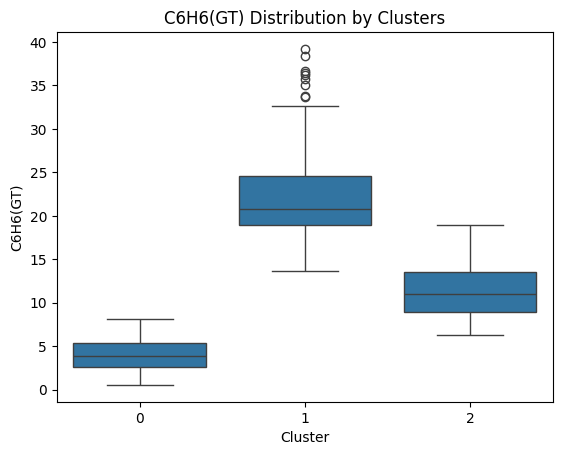

In [10]:
# Select relevant predictors for clustering (ignoring non-informative columns like 'Unnamed: 0')
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Standardize the predictor variables for clustering
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[predictor_columns])

# Apply K-Means clustering to find natural groups in the data
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose 3 clusters as an example
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the distribution of the target variable within the clusters
sns.boxplot(x='cluster', y='C6H6(GT)', data=data)
plt.title("C6H6(GT) Distribution by Clusters")
plt.xlabel("Cluster")
plt.ylabel("C6H6(GT)")
plt.show()

# Summary statistics for each cluster
cluster_summary = data.groupby("cluster")[predictor_columns + ['C6H6(GT)']].mean()

In [11]:
cluster_summary

CO(GT)  PT08.S1(CO)    NMHC(GT)  PT08.S2(NMHC)     NOx(GT)  \
cluster                                                                 
0        1.099363   981.406847   68.799363     698.687102   71.461783   
1        4.513295  1551.542389  545.693642    1349.135356  264.479769   
2        2.412941  1241.835049  220.735294    1017.883578  148.476471   

         PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)          T  \
cluster                                                                   
0         1229.687367   70.652866   1321.282643   682.866242  12.771842   
1          658.124277  137.797688   2050.468690  1598.689788  17.746869   
2          872.267402  108.502941   1629.426716  1099.391667  17.119167   

                RH        AH   C6H6(GT)  
cluster                                  
0        53.457511  0.763095   3.981506  
1        48.152698  0.936480  22.175780  
2        45.435024  0.842111  11.241603

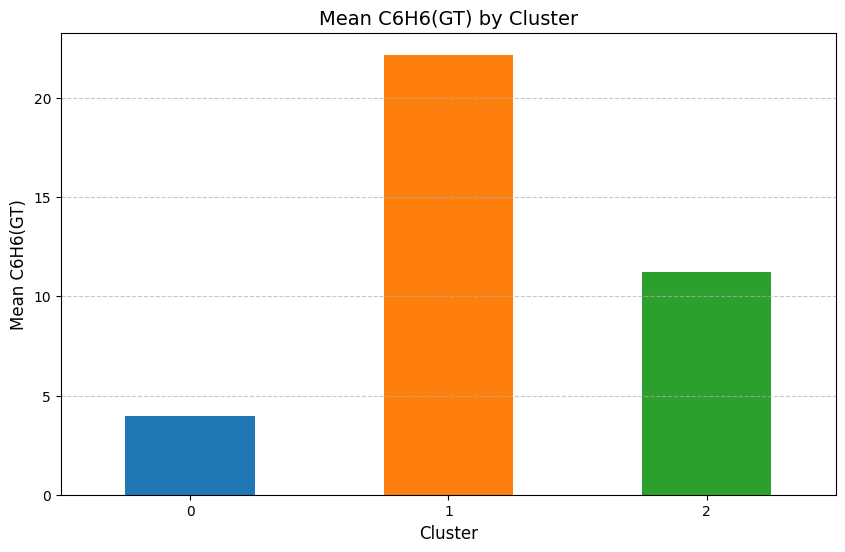

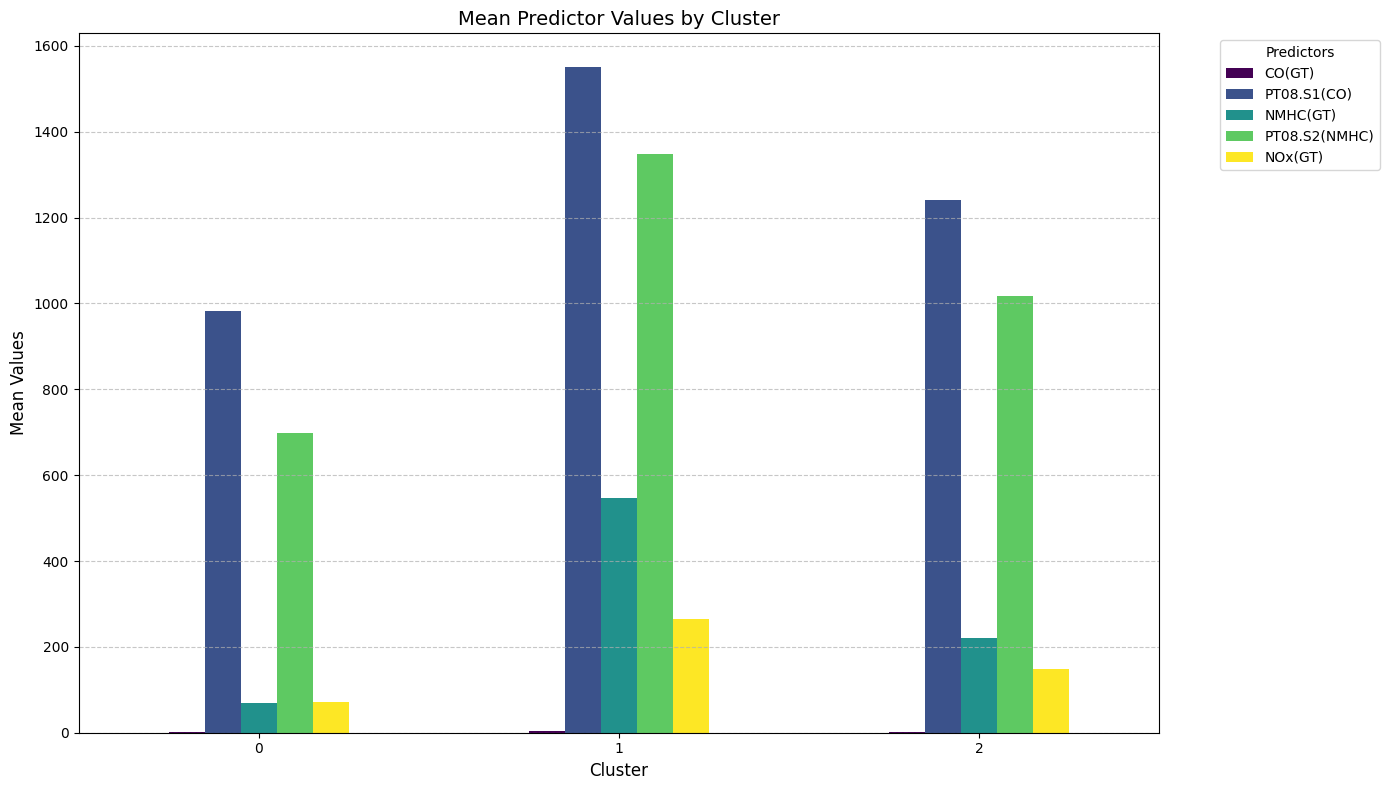

In [12]:
# Compute the mean values for each cluster
cluster_means = data.groupby("cluster")[predictor_columns + ["C6H6(GT)"]].mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
cluster_means["C6H6(GT)"].plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
ax.set_title("Mean C6H6(GT) by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean C6H6(GT)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.show()

# Visualize a subset of predictors by cluster
fig, ax = plt.subplots(figsize=(14, 8))
cluster_means[predictor_columns[:5]].plot(kind="bar", ax=ax, colormap="viridis")
ax.set_title("Mean Predictor Values by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean Values", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title="Predictors", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for hierarchical modeling
group_idx = data["cluster"].values  # Use clusters as the grouping variable
n_groups = len(np.unique(group_idx))  # Number of clusters/groups

# Define the hierarchical Bayesian model for prior predictive checks
with pm.Model() as hierarchical_model:
    # Hyperpriors for group-level parameters
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=10, shape=len(predictor_columns))  # Population-level mean for coefficients
    # sigma_beta = pm.HalfNormal("sigma_beta", sigma=2, shape=len(predictor_columns))  # Population-level variance
    # allowing lightly heavier tails
    sigma_beta = pm.HalfStudentT("sigma_beta", nu=4, sigma=2, shape=len(predictor_columns))

    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=10)  # Population-level mean for intercept
    sigma_intercept = pm.HalfStudentT("sigma_intercept", nu=4, sigma=2)#pm.HalfNormal("sigma_intercept", sigma=2)  # Population-level variance

    # Non-centered parameterization for group-level effects
    beta_raw = pm.Normal("beta_raw", mu=0, sigma=1, shape=(n_groups, len(predictor_columns)))
    beta = pm.Deterministic("beta", mu_beta + beta_raw * sigma_beta)

    intercept_raw = pm.Normal("intercept_raw", mu=0, sigma=1, shape=n_groups)
    intercept = pm.Deterministic("intercept", mu_intercept + intercept_raw * sigma_intercept)

    # Linear predictor for each group (apply exp() for Gamma likelihood)
    mu = pm.math.exp(intercept[group_idx] + pm.math.sum(beta[group_idx] * X, axis=1))

    # Shape parameter for Gamma likelihood
    alpha = pm.Exponential("alpha", lam=1)  # More stable than HalfCauchy

    # Likelihood for prior predictive (remove observed data)
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu)

    # Sample prior predictive
    hierarchical_prior_predictive = pm.sample_prior_predictive()

Sampling: [beta_raw, intercept_raw, mu_beta, mu_intercept, nu, sigma, sigma_beta, sigma_intercept, target]


In [ ]:
# Please, do not uncomment, it took us around 4 days to complete this model to train.
# with pm.Model() as hierarchical_model:
#     # Hyperpriors for group-level parameters
#     mu_beta = pm.Normal("mu_beta", mu=0, sigma=10, shape=len(predictor_columns))  # Population-level mean for coefficients
#     sigma_beta = pm.HalfStudentT("sigma_beta", nu=4, sigma=2, shape=len(predictor_columns))  # Population-level variance

#     mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=10)  # Population-level mean for intercept
#     sigma_intercept = pm.HalfStudentT("sigma_intercept", nu=4, sigma=2)  # Population-level variance

#     # Non-centered parameterization for group-level effects
#     beta_raw = pm.Normal("beta_raw", mu=0, sigma=1, shape=(n_groups, len(predictor_columns)))
#     beta = pm.Deterministic("beta", mu_beta + beta_raw * sigma_beta)

#     intercept_raw = pm.Normal("intercept_raw", mu=0, sigma=1, shape=n_groups)
#     intercept = pm.Deterministic("intercept", mu_intercept + intercept_raw * sigma_intercept)

#     # Linear predictor for each group
#     mu = intercept[group_idx] + pm.math.sum(beta[group_idx] * X, axis=1)

#     # Degrees of freedom for Student-t distribution (controls tail heaviness)
#     nu = pm.Gamma("nu", alpha=2, beta=0.1)  # Higher values make it approach normal

#     # Likelihood using Student-t instead of Gamma
#     target = pm.StudentT("target", nu=nu, mu=mu, sigma=pm.Exponential("sigma", lam=1), observed=y)

#     # Sample prior predictive
#     hierarchical_prior_predictive = pm.sample_prior_predictive()


In [ ]:
# Define the hierarchical Bayesian model
with hierarchical_model:
    # Initialize model with a custom start point
    initial_point = hierarchical_model.initial_point()
    
    # Sample the posterior
    hierarchical_trace = pm.sample(
        3000,
        tune=3000, 
        init="adapt_diag", 
        chains=4, 
        target_accept=0.99, 
        max_treedepth=20, 
        return_inferencedata=True
    )

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [mu_beta, sigma_beta, mu_intercept, sigma_intercept, beta_raw, intercept_raw, nu, sigma]


Output()

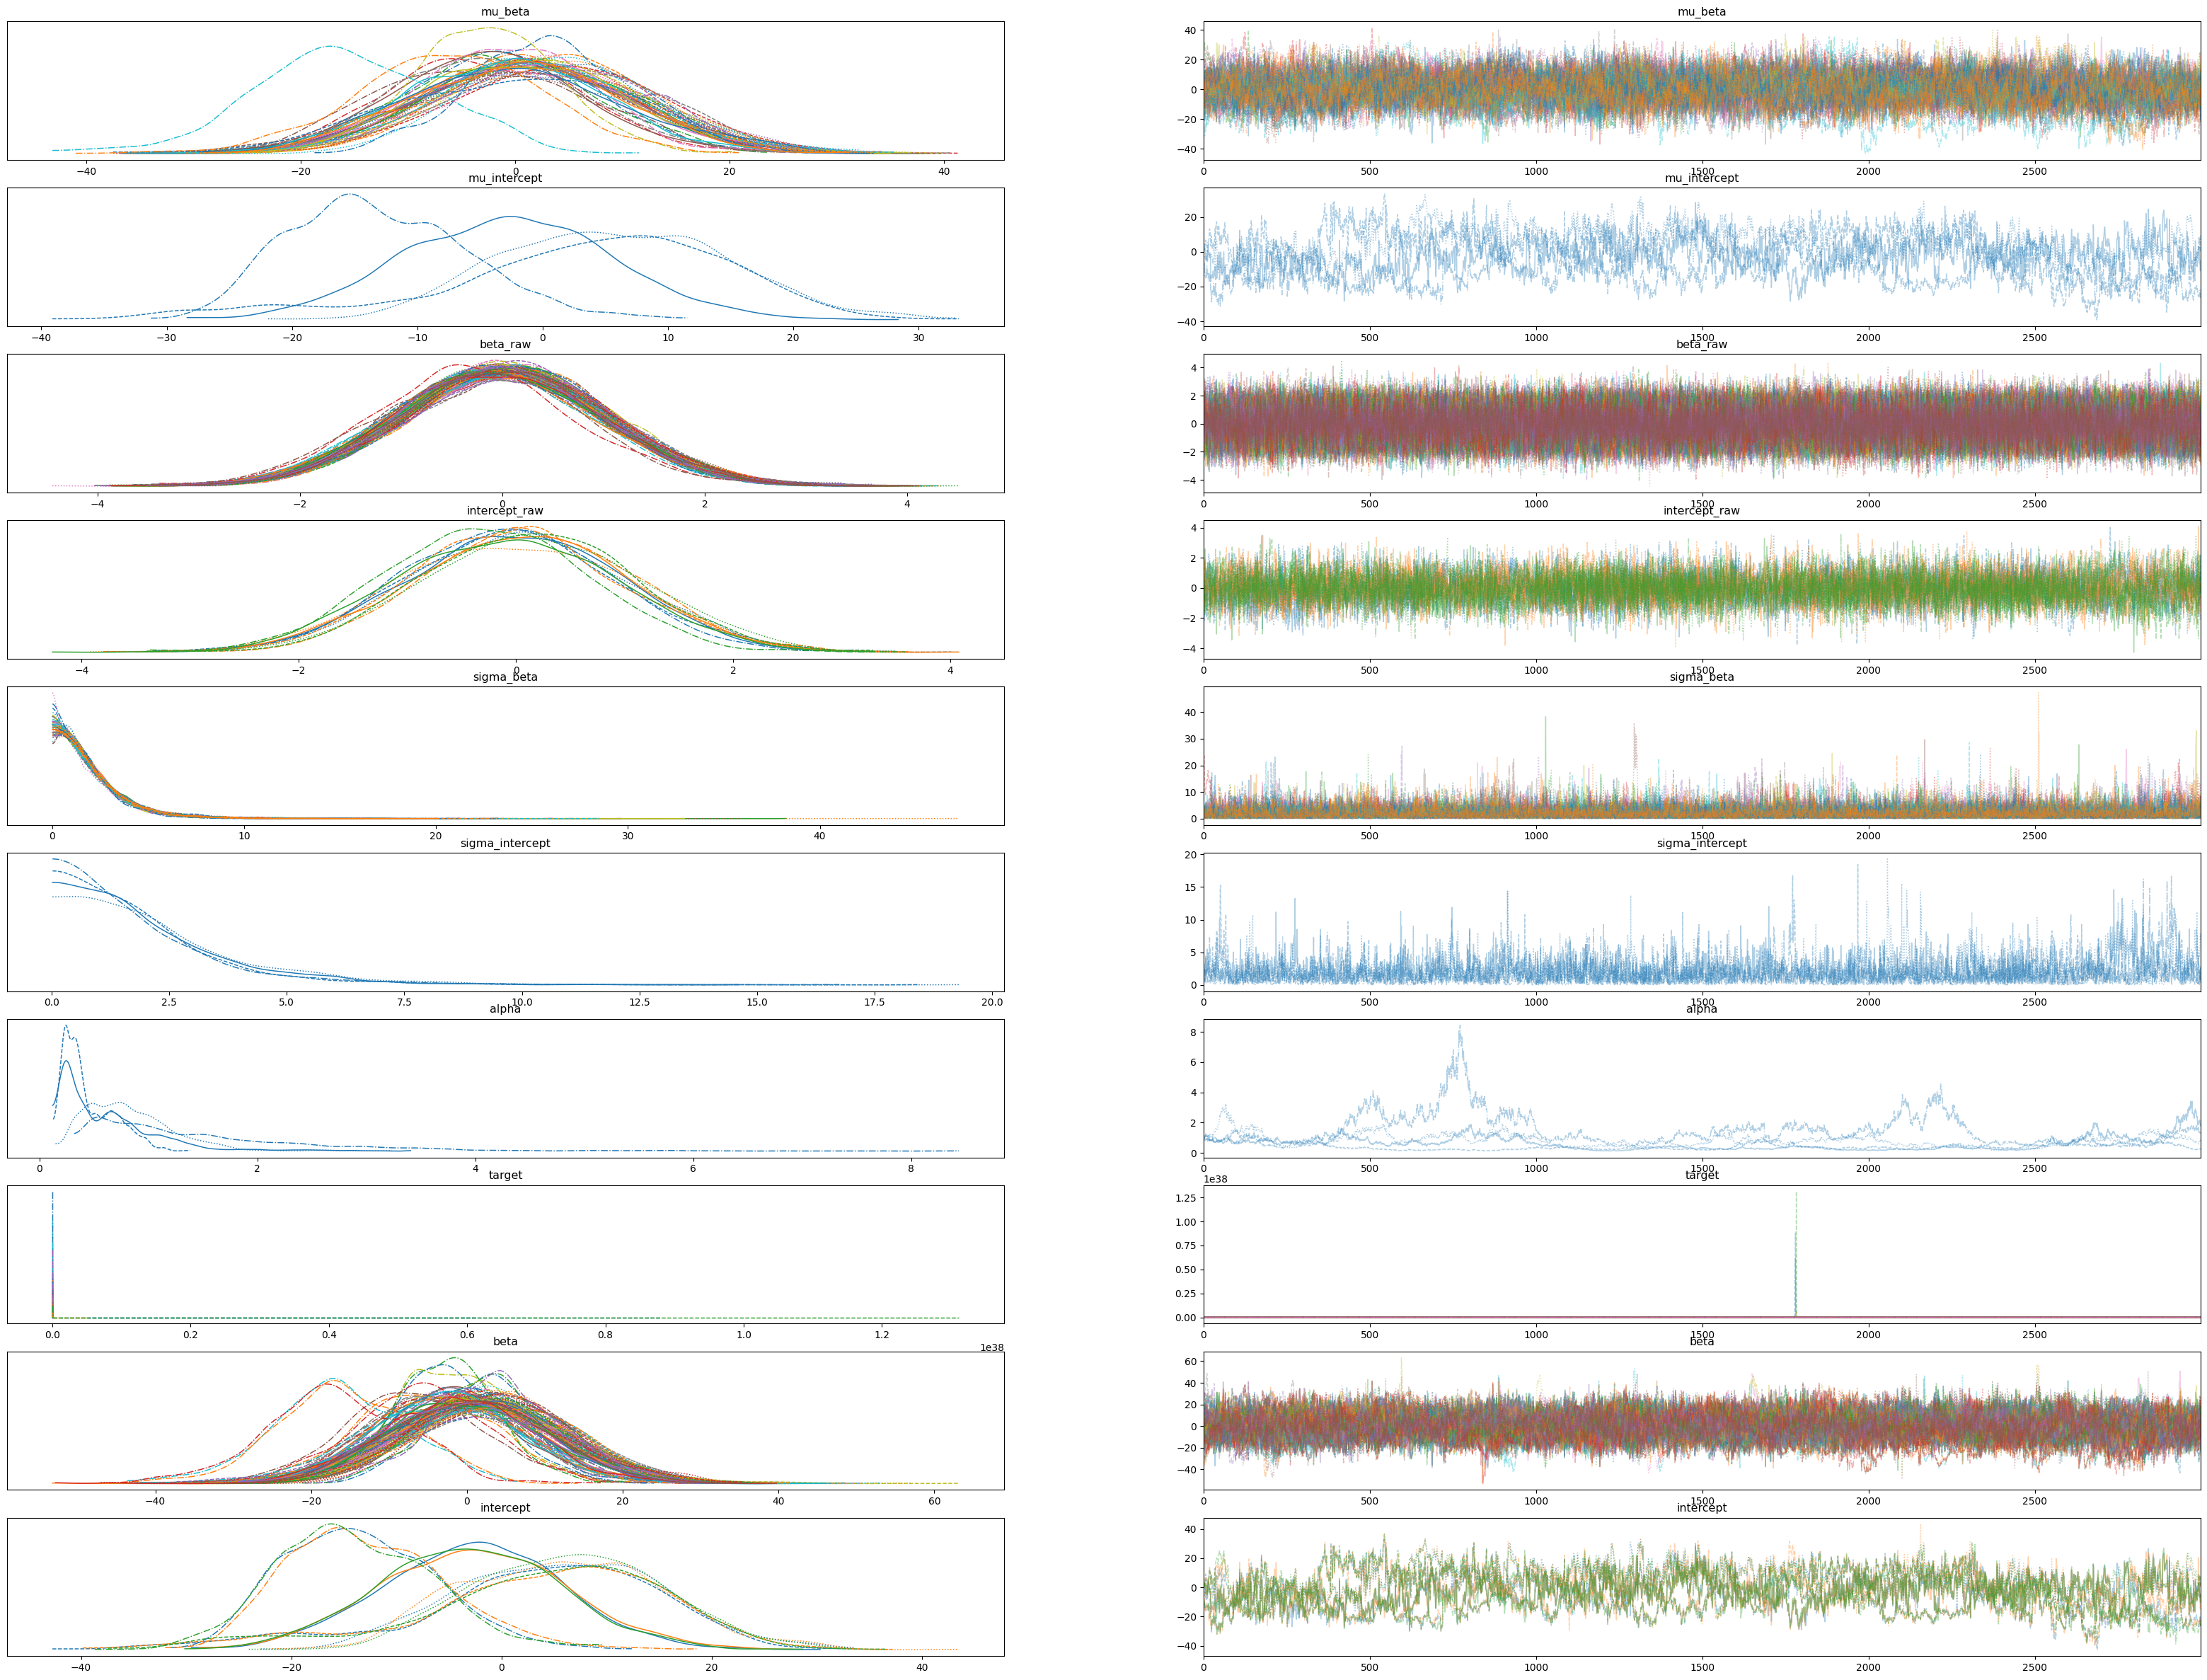

In [28]:
# Save and display posterior diagnostics
# posterior_summary = az.summary(student_t_summary)
az.plot_trace(hierarchical_trace, figsize=(40, 30), compact=True) #, var_names=scaled_data.columns
# plt.savefig("traceplot_beta_intercept_alpha.png")
plt.show()

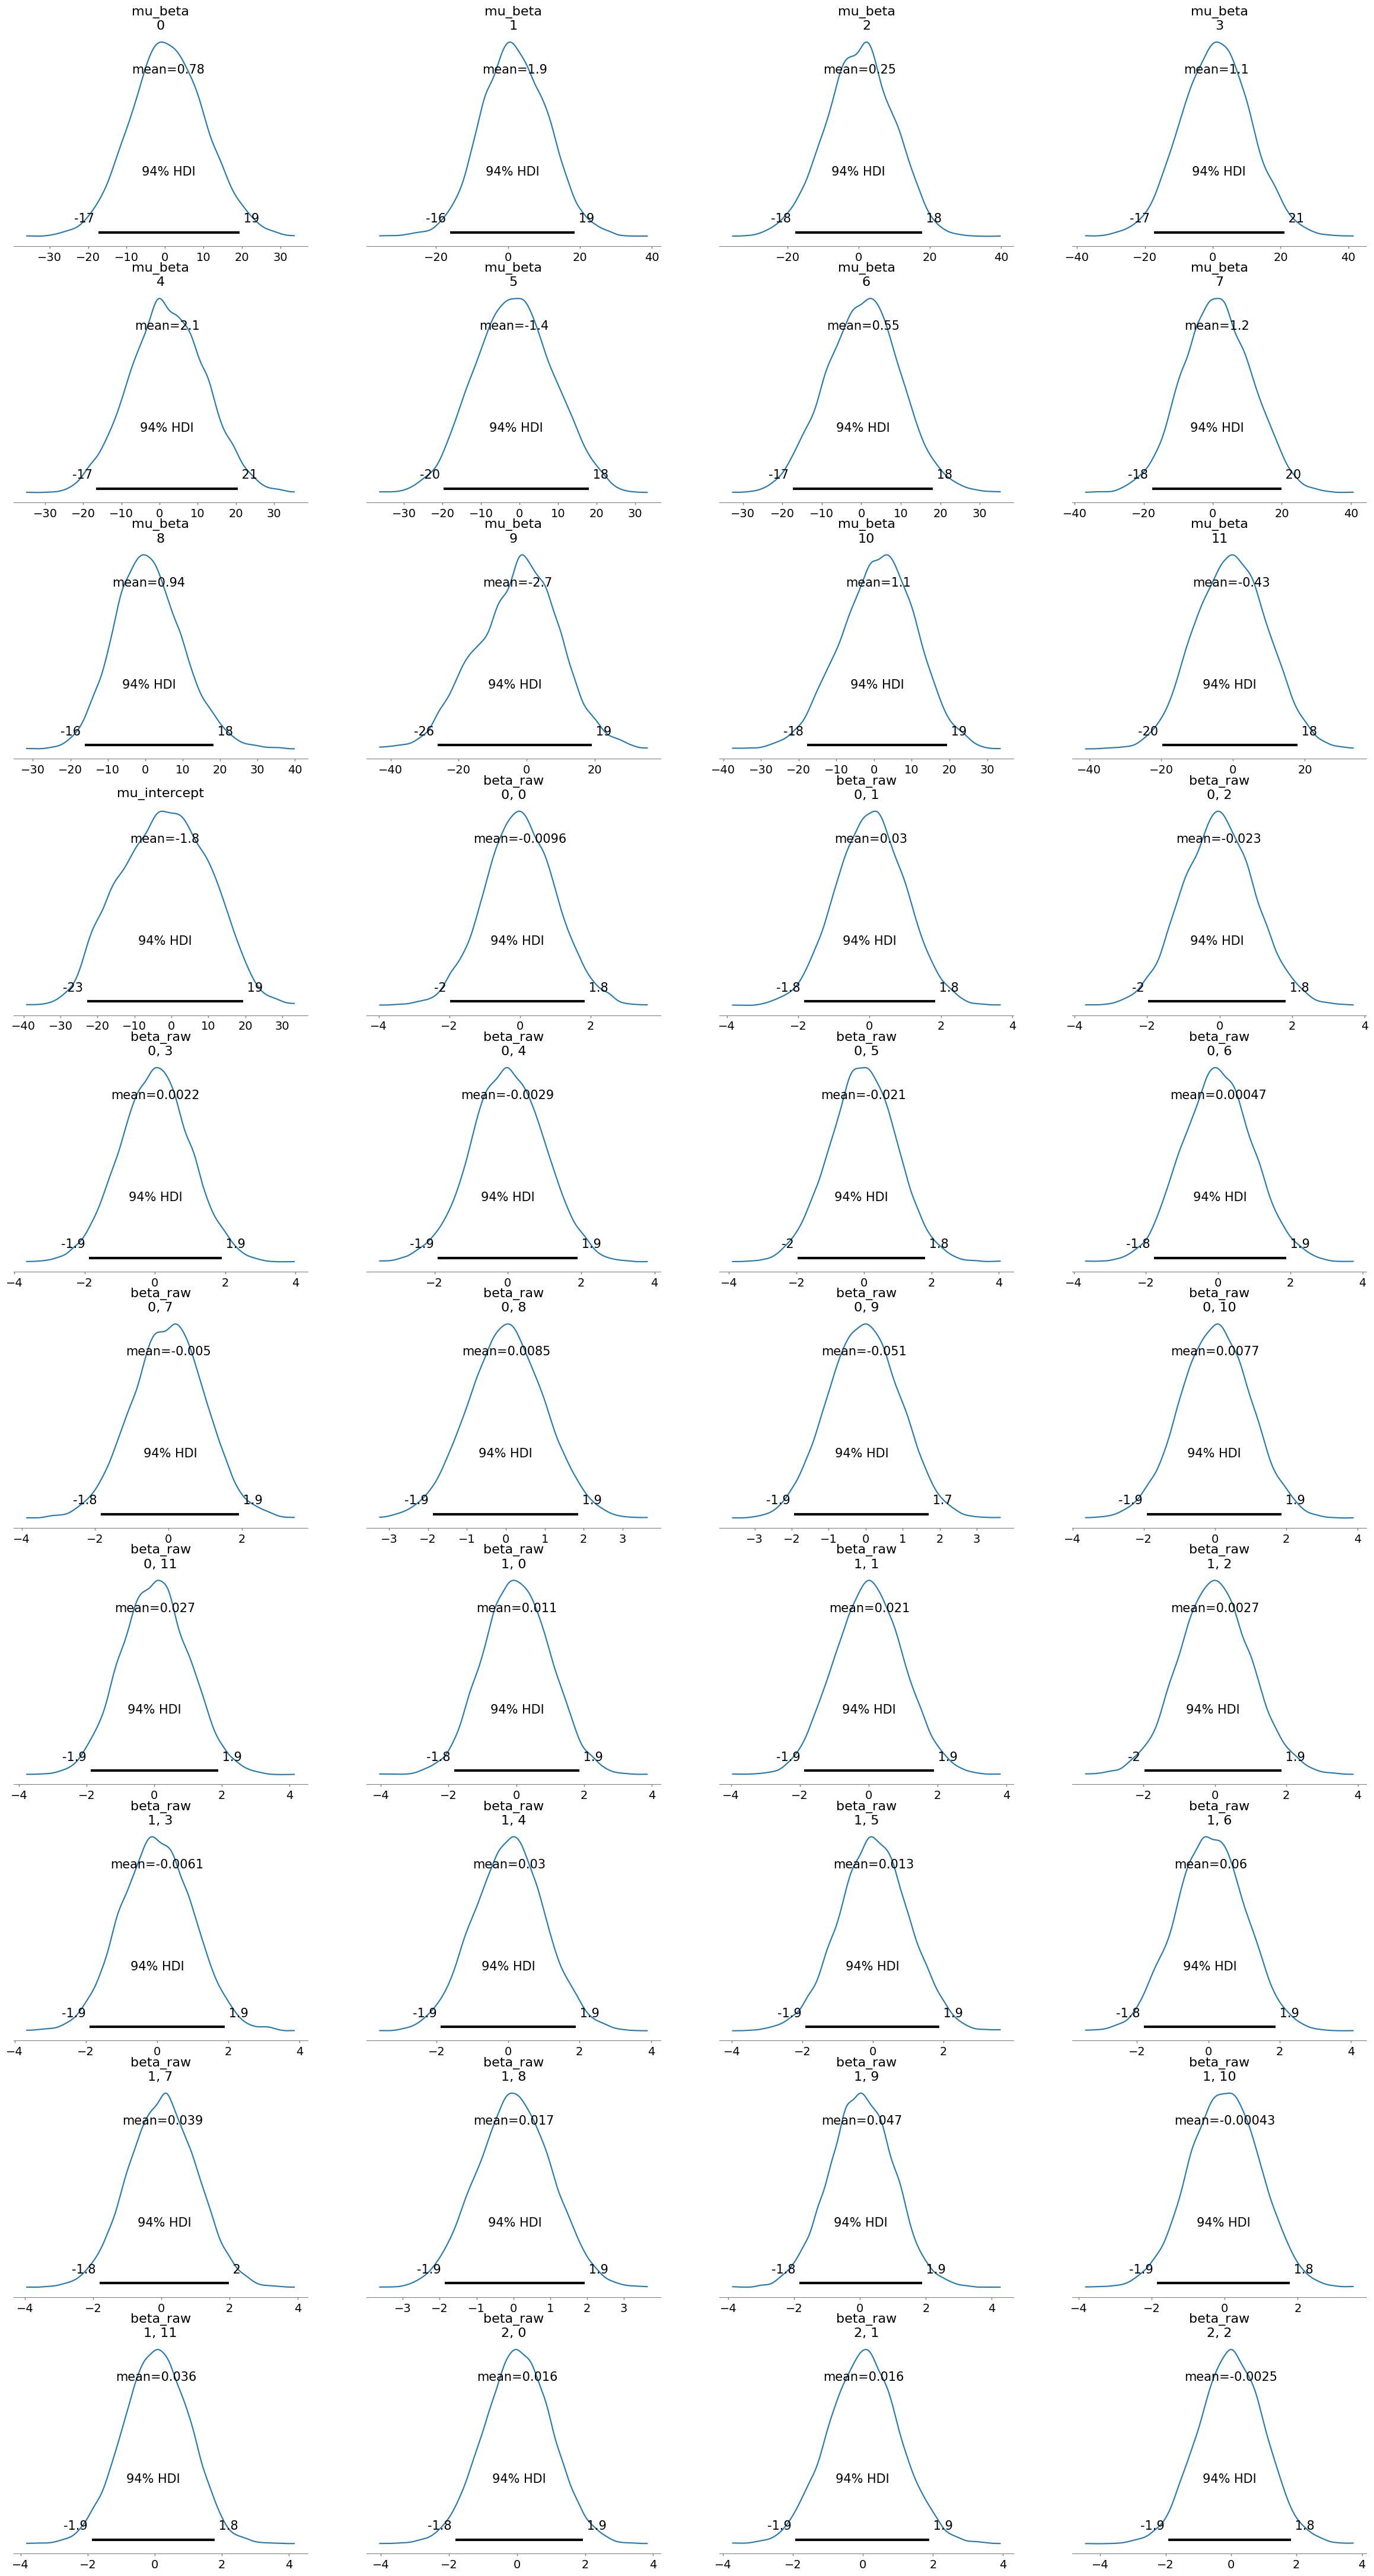

In [29]:
az.plot_posterior(hierarchical_trace.posterior)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

In [30]:
hierarchical_prior_predictive.prior["beta"].values.shape

(1, 500, 3, 12)

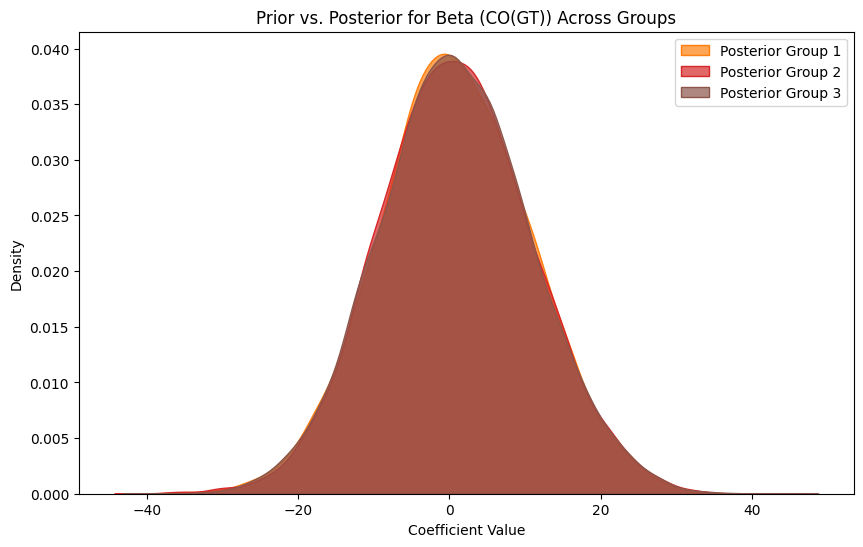

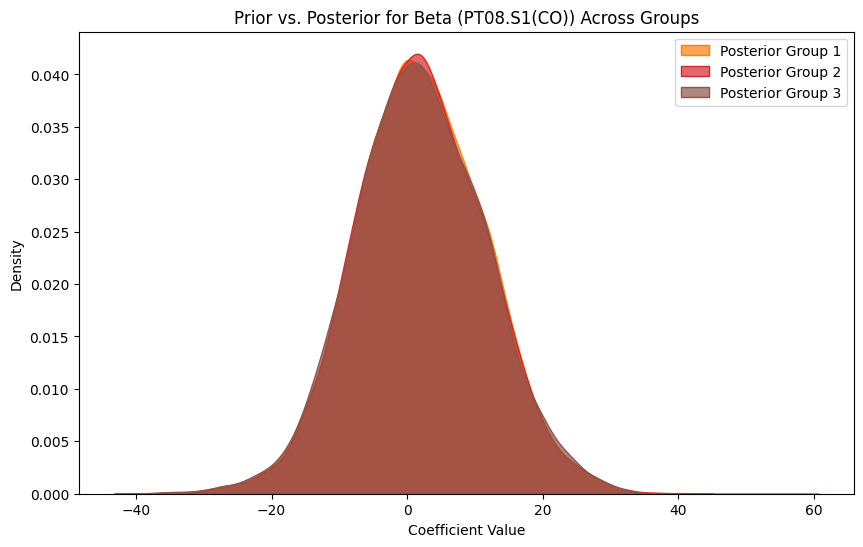

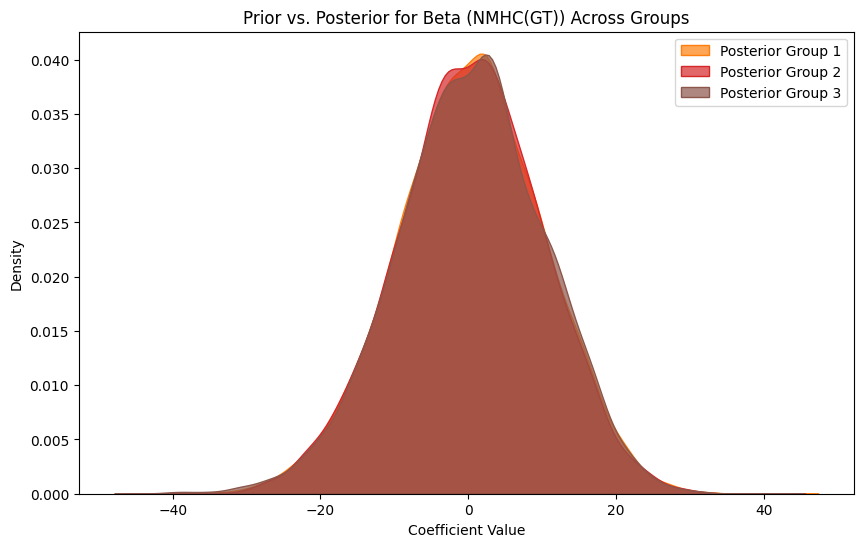

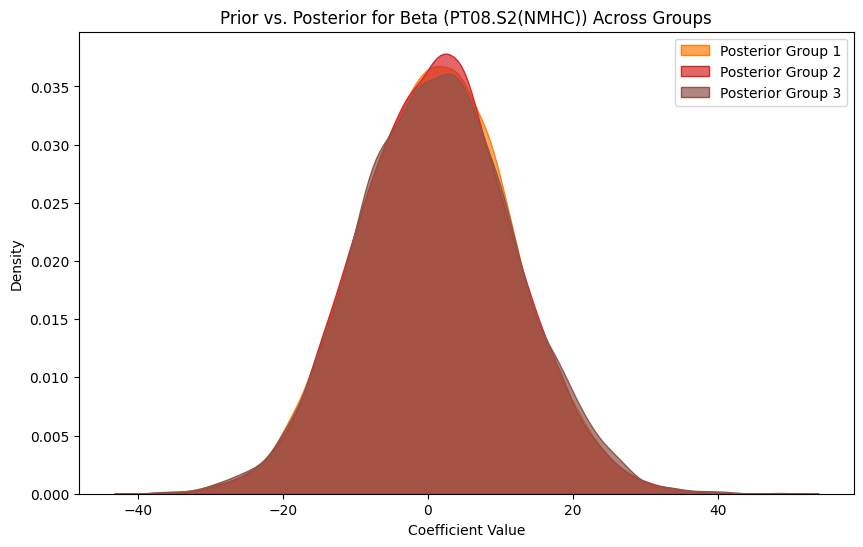

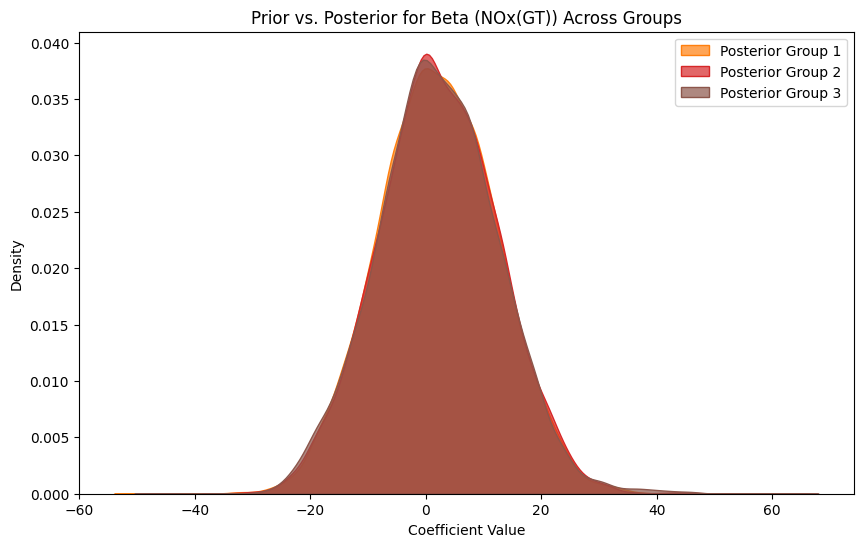

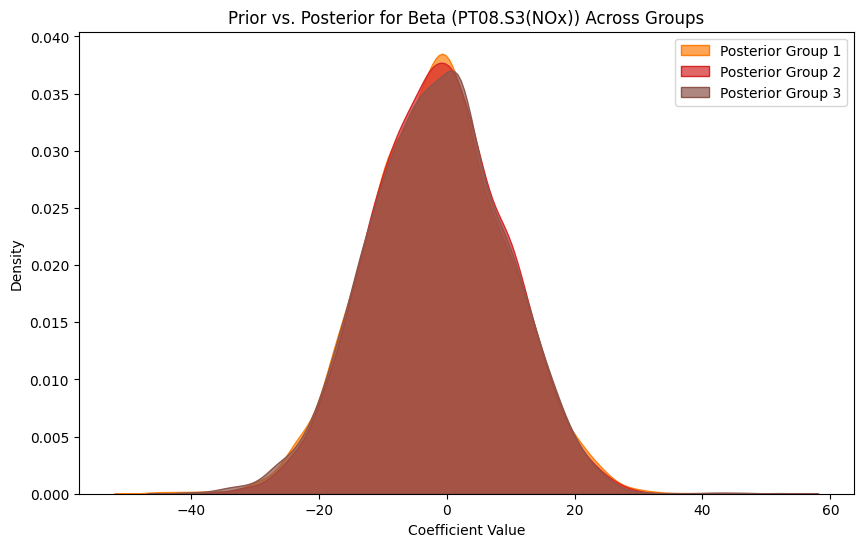

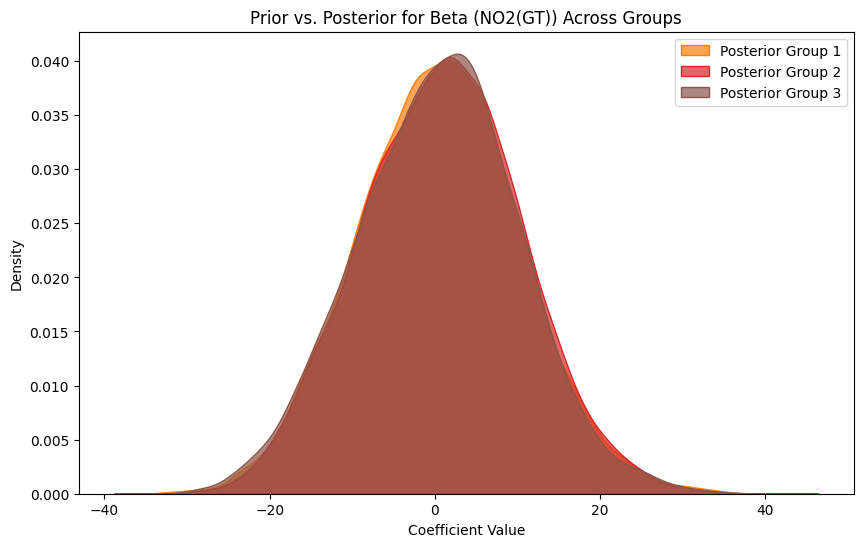

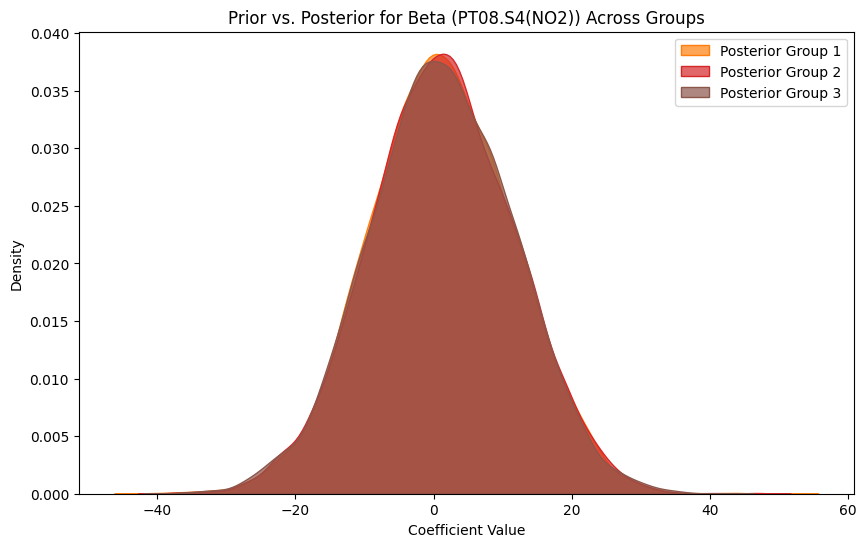

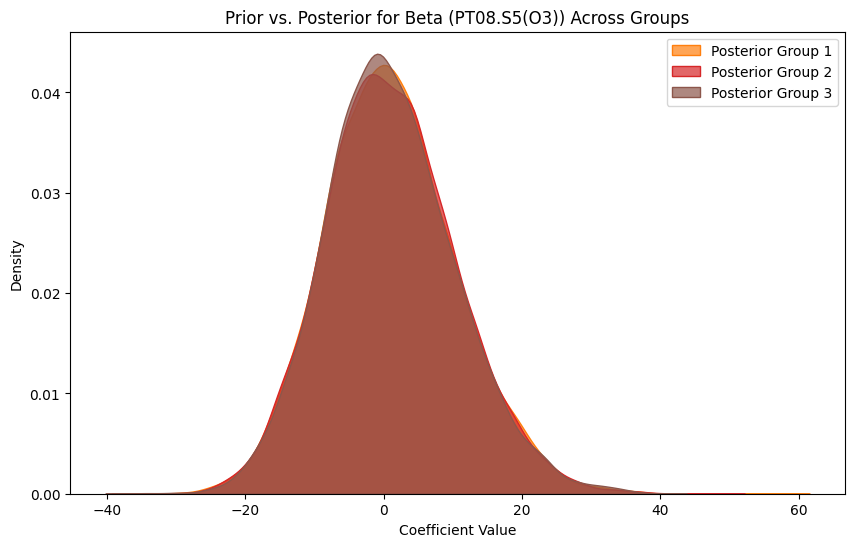

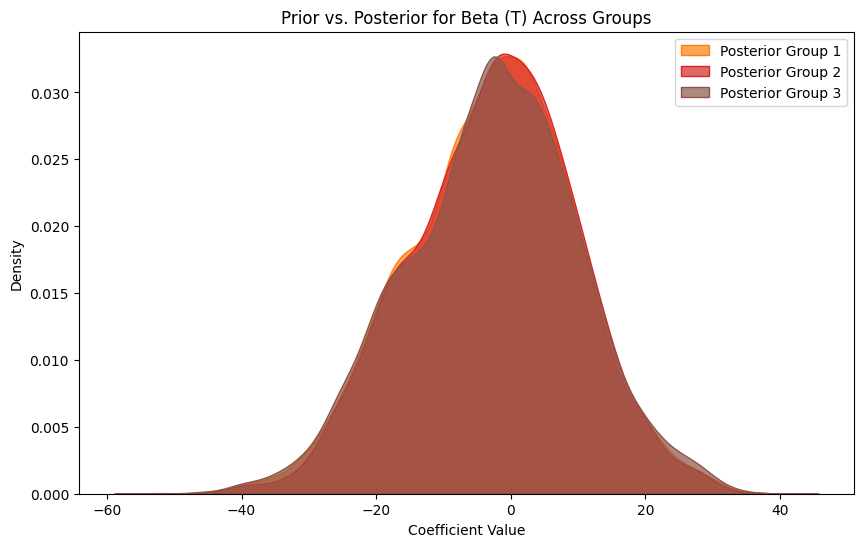

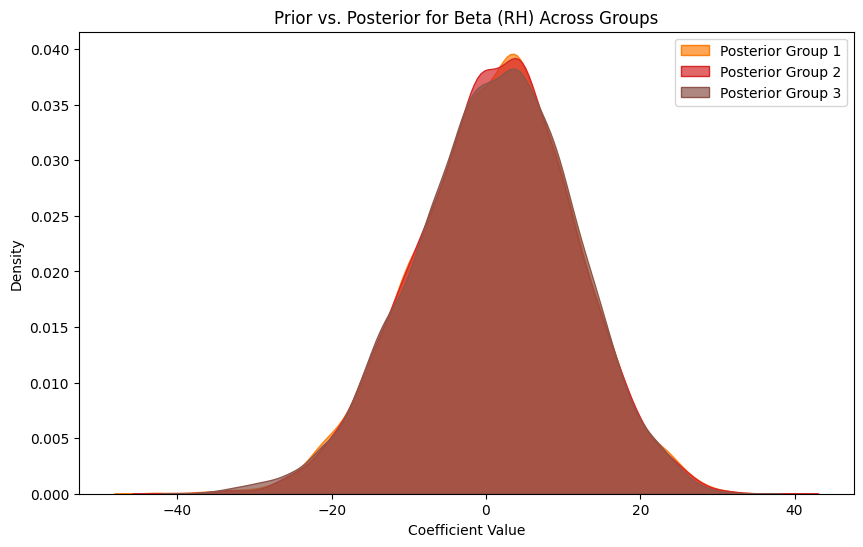

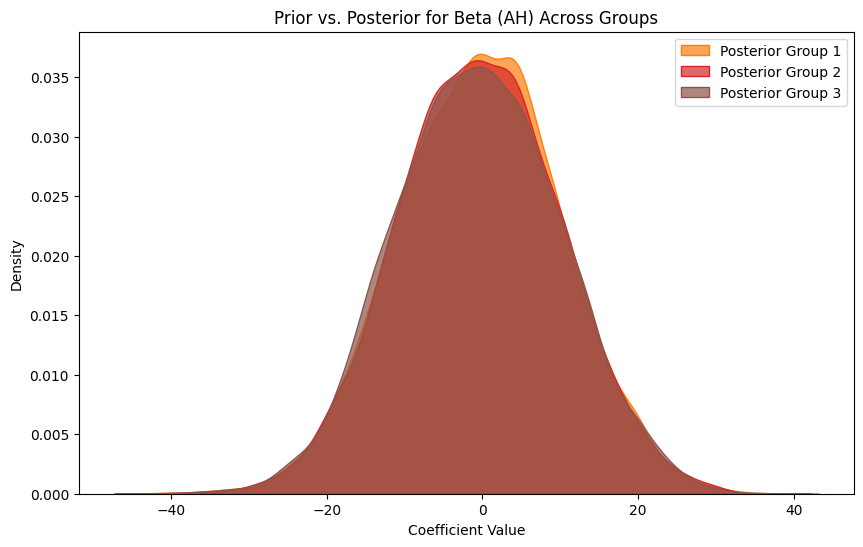

In [31]:
# Compare priors and posteriors for beta (coefficients)
for i, feature in enumerate(predictor_columns):
    plt.figure(figsize=(10, 6))
    for group in range(n_groups):  # Iterate over groups
        prior_samples = hierarchical_prior_predictive.prior["beta"].values[:, :, group, i]#.flatten() #.sel(beta_dim_0=group, beta_dim_1=i).values.flatten()#
        # print(prior_samples.shape)
        posterior_samples = hierarchical_trace.posterior["beta"].sel(beta_dim_0=group, beta_dim_1=i).values.flatten()

        sns.kdeplot(prior_samples, fill=True, alpha=0.3, label=f"Prior Group {group + 1}")
        sns.kdeplot(posterior_samples, fill=True, alpha=0.7, label=f"Posterior Group {group + 1}")

    plt.title(f"Prior vs. Posterior for Beta ({feature}) Across Groups")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# # Compare priors and posteriors for intercepts
# plt.figure(figsize=(10, 6))
# for group in range(n_groups):  # Iterate over groups
#     prior_samples = hierarchical_prior_predictive.prior["intercept"][:, group].flatten()
#     posterior_samples = hierarchical_trace.posterior["intercept"].sel(intercept_dim_0=group).values.flatten()

#     sns.kdeplot(prior_samples, fill=True, alpha=0.3, label=f"Prior Group {group + 1}")
#     sns.kdeplot(posterior_samples, fill=True, alpha=0.7, label=f"Posterior Group {group + 1}")

# plt.title("Prior vs. Posterior for Intercepts Across Groups")
# plt.xlabel("Intercept Value")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

In [32]:
with hierarchical_model:
    # log_likelihood_gamma = 
    pm.compute_log_likelihood(hierarchical_trace)

Output()

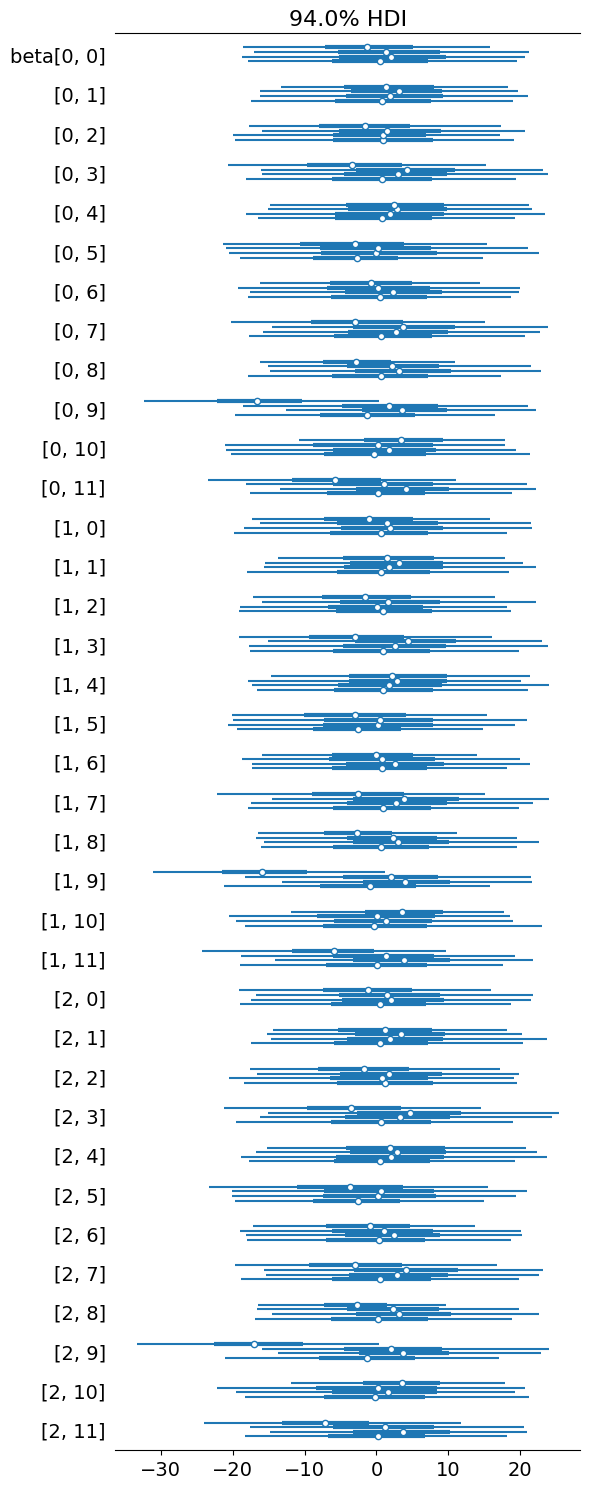

In [33]:
az.plot_forest(hierarchical_trace, var_names="beta");

In [34]:
# Compute WAIC and LOO for Model Comparison
try:
    # Compute WAIC
    hierarchical_waic = az.waic(hierarchical_trace)
    print(f"WAIC: {hierarchical_waic}")

    # Compute LOO
    hierarchical_loo = az.loo(hierarchical_trace)
    print(f"LOO: {hierarchical_loo}")

except Exception as e:
    print("Error in computing WAIC/LOO:", str(e))

Error in computing WAIC/LOO: log likelihood not found in inference data object
